<a href="https://colab.research.google.com/github/tasty-orange/ARN-labs/blob/main/ARN_PW3_PT2_Piemontesi_Trueb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Work 3 ARN - G.Piemontesi & G.Trueb

## Deuxième expérience : Classification « awake », « n-rem » et « rem ».

Dans cette expérience, nous allons classifier les états des souris en trois classes : « awake » , « NREM » et « REM ». L'objectif est de créer un modèle MLP capable de prédire ces trois états à partir des données EEG des souris. Nous évaluerons les performances du modèle à l'aide de la perte d'entraînement, de la validation, de la matrice de confusion et du F1-score.

### Import des packages/dépendances



In [1]:
# Importation des bibliothèques nécessaires
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Input, Dense
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras import regularizers
from tensorflow import keras
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

### Import des données des souris

In [2]:
# Chargement des données d'entraînement
mice_eeg_1 = pd.read_csv('EEG_mouse_data_1.csv')
mice_eeg_2 = pd.read_csv('EEG_mouse_data_2.csv')

# Fusion des deux jeux de données d'entraînement
data_training = pd.concat([mice_eeg_1, mice_eeg_2])

###Preprocessing et normalisation des données

Comme on peut le voir dans le diagramme en barres ci-dessous, le sommeil des souris se divise en trois états : « awake », « NREM » et « REM ». Contrairement à l'approche binaire de la première expérience, nous conservons ici ces trois classes distinctes pour l'analyse.

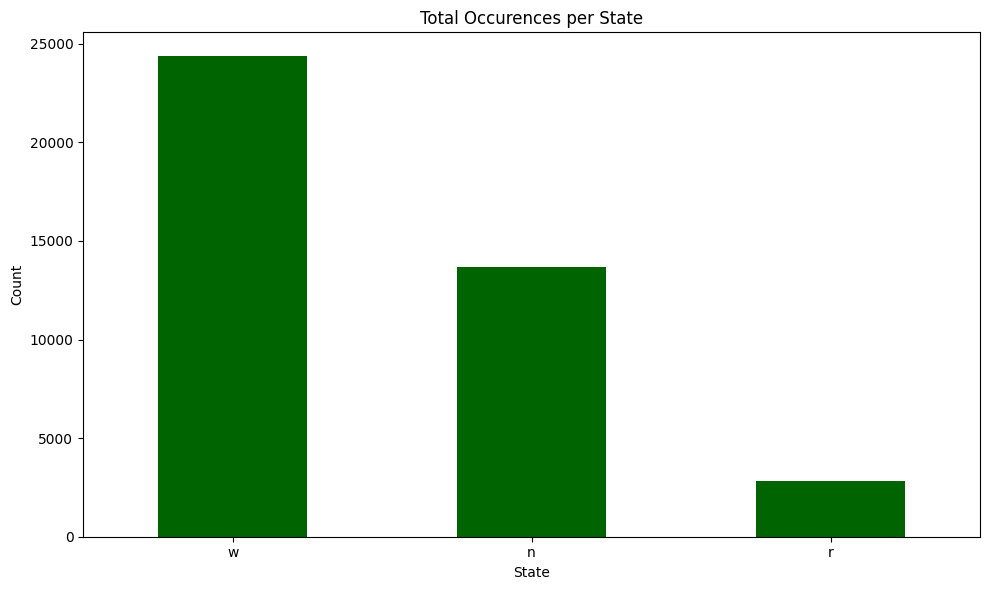

In [3]:
# Visualisation de la distribution des états
plt.figure(figsize=(10, 6))
data_training.state.value_counts().plot(kind='bar', color='darkgreen')
plt.title('Total Occurences per State')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.xlabel('State')
plt.tight_layout()
plt.show()

In [4]:
# Séparer les caractéristiques et la variable cible
input_data = data_training.drop('state', axis=1).values
output_data = data_training['state'].values

# Garder seulement les 25 premières caractéristiques
input_data = input_data[:, :25]

# Normaliser les données d'entrée
scaler = StandardScaler()
input_data = scaler.fit_transform(input_data)

# Encoder la variable cible
# D'abord avec LabelEncoder pour obtenir des valeurs numériques
label_encoder = LabelEncoder()
output_labels = label_encoder.fit_transform(output_data)

# Puis appliquer l'encodage One-Hot
# Reshape les données de sortie pour appliquer OneHotEncoder
output_reshaped = output_labels.reshape(-1, 1)

# Appliquer l'encodage One-Hot
one_hot_encoder = OneHotEncoder(sparse_output=False)
output_data_onehot = one_hot_encoder.fit_transform(output_reshaped)

# Définir la validation croisée
kf = KFold(n_splits=3, shuffle=True, random_state=1)

### Creation du modèle MLP


In [5]:
# Définition de la fonction de création du modèle
def create():
    model = Sequential([
        # Entrée avec les caractéristiques
        Input(shape=(25,)),

        # Première couche cachée avec régularisation L2
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

        # Deuxième couche cachée avec régularisation L2
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

        # Dropout pour éviter le surapprentissage
        Dropout(0.3),

        # Couche de sortie pour 3 classes
        Dense(3, activation='softmax')
    ])

    # Compilation du modèle avec categorical_crossentropy pour la classification multiclasse
    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model

# Création du modèle
model = create()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,843 (15.01 KB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 0 (0.00 B)

### Entraînement du modèle

Epoch 1/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8012 - loss: 0.6035 - val_accuracy: 0.8775 - val_loss: 0.3986
Epoch 2/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8717 - loss: 0.4130 - val_accuracy: 0.8820 - val_loss: 0.3711
Epoch 3/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8793 - loss: 0.3805 - val_accuracy: 0.8824 - val_loss: 0.3597
Epoch 4/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8810 - loss: 0.3710 - val_accuracy: 0.8836 - val_loss: 0.3518
Epoch 5/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8823 - loss: 0.3627 - val_accuracy: 0.8826 - val_loss: 0.3538
Epoch 6/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8798 - loss: 0.3624 - val_accuracy: 0.8827 - val_loss: 0.3445
Epoch 7/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8823 - loss: 0.3533 - val_accuracy: 0.8812 - val_loss: 0.3494
Epoch 8/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8837 - loss: 0.3533 - val_accuracy: 0.

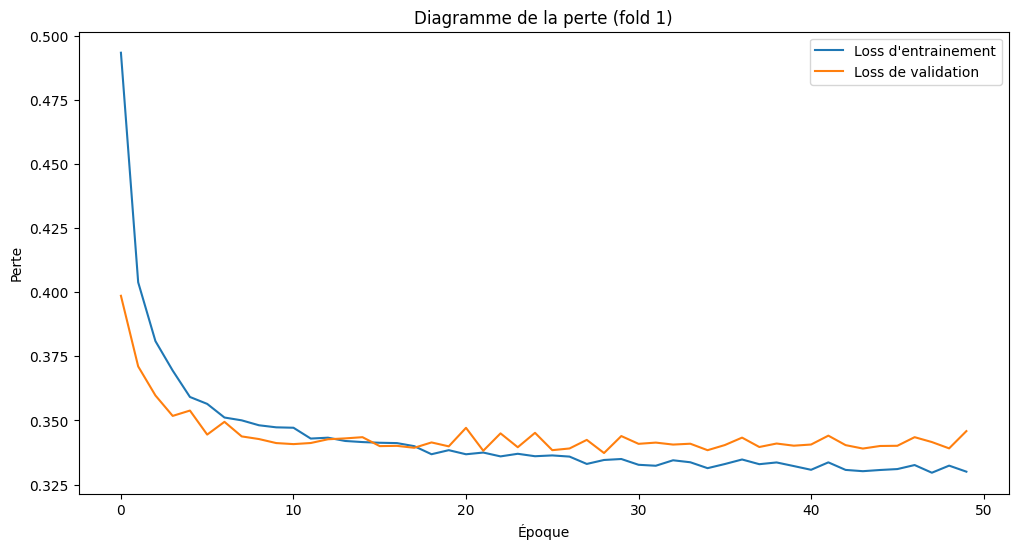

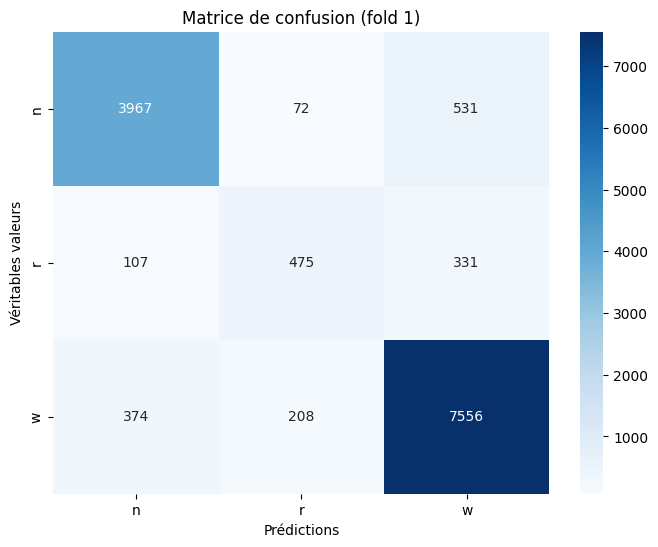

Epoch 1/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8146 - loss: 0.5911 - val_accuracy: 0.8725 - val_loss: 0.4166
Epoch 2/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8752 - loss: 0.4127 - val_accuracy: 0.8771 - val_loss: 0.3906
Epoch 3/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8793 - loss: 0.3828 - val_accuracy: 0.8772 - val_loss: 0.3769
Epoch 4/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8827 - loss: 0.3705 - val_accuracy: 0.8770 - val_loss: 0.3692
Epoch 5/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8847 - loss: 0.3537 - val_accuracy: 0.8789 - val_loss: 0.3601
Epoch 6/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8856 - loss: 0.3464 - val_accuracy: 0.8778 - val_loss: 0.3606
Epoch 7/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8832 - loss: 0.3506 - val_accuracy: 0.8793 - val_loss: 0.3552
Epoch 8/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8869 - loss: 0.3408 - val_accuracy: 0.

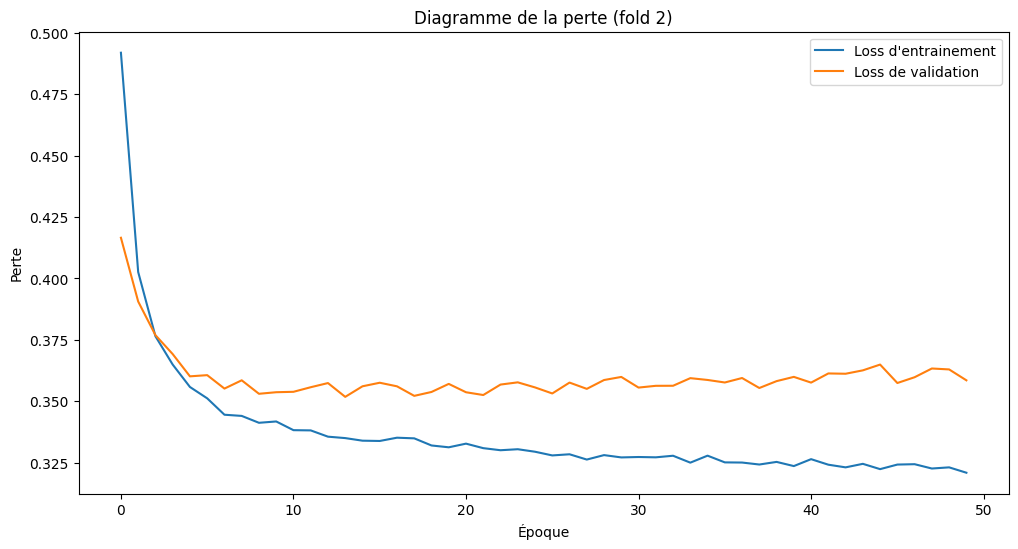

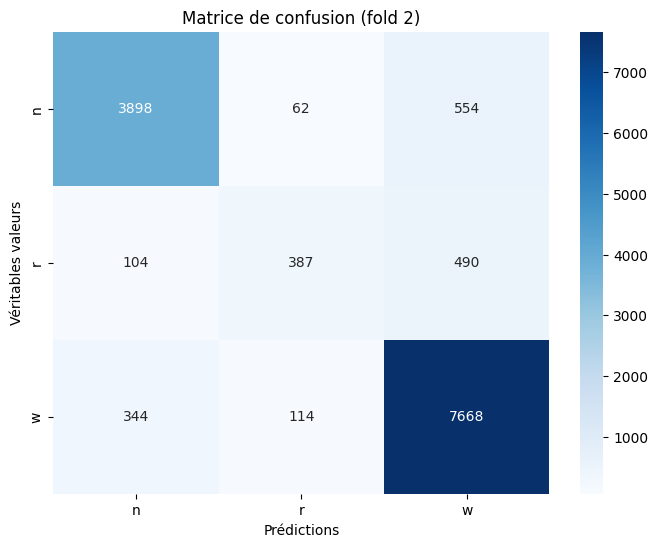

Epoch 1/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8182 - loss: 0.5751 - val_accuracy: 0.8779 - val_loss: 0.4049
Epoch 2/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8730 - loss: 0.4137 - val_accuracy: 0.8811 - val_loss: 0.3768
Epoch 3/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8802 - loss: 0.3852 - val_accuracy: 0.8836 - val_loss: 0.3582
Epoch 4/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8780 - loss: 0.3767 - val_accuracy: 0.8833 - val_loss: 0.3488
Epoch 5/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8795 - loss: 0.3667 - val_accuracy: 0.8829 - val_loss: 0.3463
Epoch 6/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8786 - loss: 0.3600 - val_accuracy: 0.8840 - val_loss: 0.3418
Epoch 7/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8803 - loss: 0.3509 - val_accuracy: 0.8851 - val_loss: 0.3392
Epoch 8/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8799 - loss: 0.3523 - val_accuracy: 0.

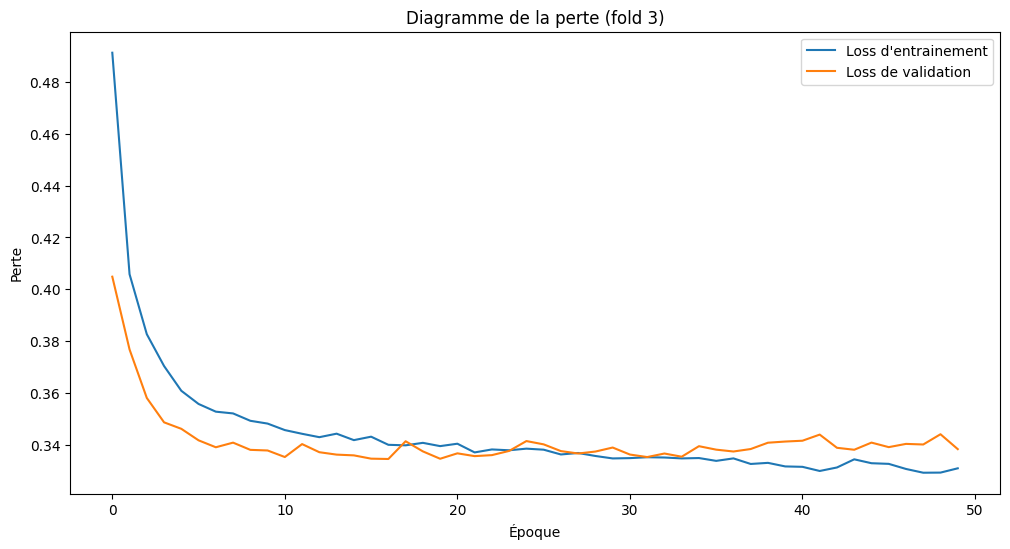

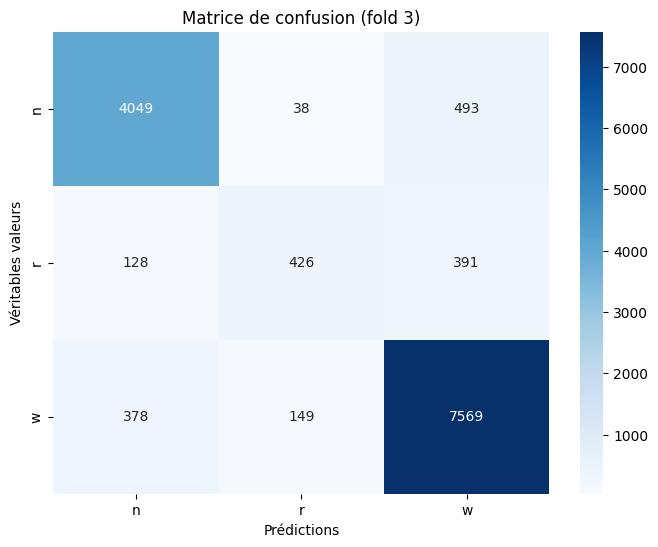

Précision moyenne : 0.8809
Écart type de la précision : 0.0027


In [6]:
# Liste pour stocker les scores de précision
accuracy_scores = []

# Diviser les données en plis pour la validation croisée
for fold, (train_index, test_index) in enumerate(kf.split(input_data)):
    # Diviser les données d'entraînement et de test
    X_train, X_test = input_data[train_index], input_data[test_index]
    y_train, y_test = output_data_onehot[train_index], output_data_onehot[test_index]

    # Créer le modèle
    model = create()

    # Entraîner le modèle et récupérer l'historique
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

    # Prédictions sur les données de test
    y_pred = model.predict(X_test)

    # Calculer la précision du modèle sur le pli actuel
    accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
    accuracy_scores.append(accuracy)

    # Afficher le diagramme de la perte (loss) par époque
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Loss d\'entrainement')
    plt.plot(history.history['val_loss'], label='Loss de validation')
    plt.title(f'Diagramme de la perte (fold {fold+1})')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.legend()
    plt.show()

    # Afficher la matrice de confusion
    cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Matrice de confusion (fold {fold+1})')
    plt.xlabel('Prédictions')
    plt.ylabel('Véritables valeurs')
    plt.show()

# Afficher la précision moyenne et l'écart type des scores
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

print(f"Précision moyenne : {mean_accuracy:.4f}")
print(f"Écart type de la précision : {std_accuracy:.4f}")

### Évaluation du modèle sur le jeu de données de test

In [12]:
# Chargement des données de test
data_test = pd.read_csv('EEG_mouse_data_test.csv')

  91/2504 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


2504/2504 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


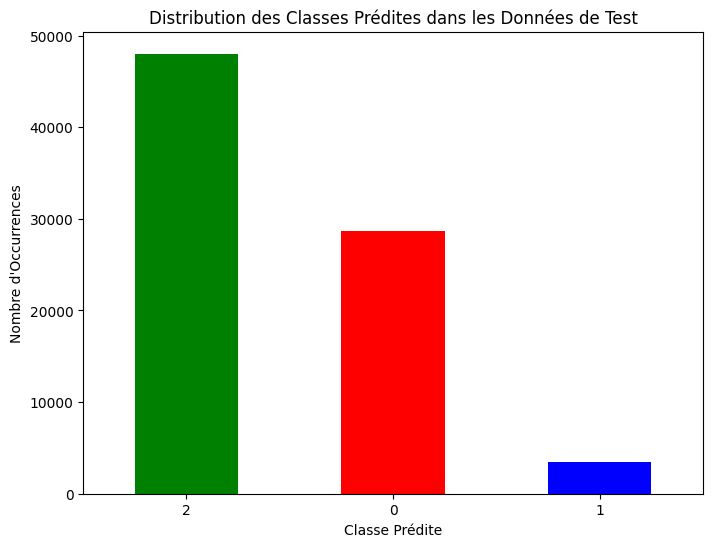

In [18]:
# Prendre les 25 premières caractéristiques de l'entraînement
columns_used_for_training = data_training.drop('state', axis=1).columns[:25]

# Sélectionner uniquement ces 25 colonnes dans les données de test
data_test_selected = data_test[columns_used_for_training]

# Normaliser les données de test avec le même scaler
X_test_final_normalized = scaler.transform(data_test_selected)

# Prédiction des classes pour les données de test
y_pred_final = model.predict(X_test_final_normalized)

# Créer un DataFrame pour les prédictions et les enregistrer dans un fichier CSV
predictions_df = pd.DataFrame(predicted_classes, columns=['Predicted_Class'])

# Enregistrer dans un fichier CSV
# predictions_df.to_csv('predictions_test.csv', index=False)

# Afficher le message de confirmation
# print("Les prédictions ont été enregistrées dans 'predictions_test.csv'.")

# Plot en barres de la distribution des classes prédites avec trois couleurs différentes
plt.figure(figsize=(8, 6))
predictions_df['Predicted_Class'].value_counts().plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Distribution des Classes Prédites dans les Données de Test')
plt.xlabel('Classe Prédite')
plt.ylabel('Nombre d\'Occurrences')
plt.xticks(rotation=0)
plt.show()
